You can check [here](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md) to get needed environment, but you don't need to worry it in colab.

In [6]:
## install dependencies: (use cu101 because colab has CUDA 10.1)
#!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
#!pip install cython pyyaml==5.1
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
#!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
#!pip3 install opencv-python

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import cv2
!gcc --version

1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [7]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

We have to take the data out from the .txt file.

In [9]:
import csv
train, test = [],[]
def take_path(x,d):
    with open(d) as t:
        #print(t.read())
        #print(type(csv.reader(t)))
        tmp = csv.reader(t,delimiter=' ')
        for i in tmp:
            x.append(i)

take_path(test,'DeepSign/trainval.txt')
print(test[:2])
take_path(train,'DeepSign/trainval.txt')
print(train[:2])

[['DeepSign/data/00005.png', 'DeepSign/labels/00005.txt'], ['DeepSign/data/00002.png', 'DeepSign/labels/00002.txt']]
[['DeepSign/data/00005.png', 'DeepSign/labels/00005.txt'], ['DeepSign/data/00002.png', 'DeepSign/labels/00002.txt']]


In [10]:
height, width = cv2.imread(test[0][0]).shape[:2]
print(height, width)

720 1280


# New Section

In [11]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#DatasetCatalog.clear()
#If you want to clear the data you registered, uncomment the upper line.

def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
        
        
        objs = []
        with open(path[1]) as t:
            lines = t.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')


                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])

                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    #you will need this for mask RCNN
                    "category_id": category-1,
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

In [12]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d,x in [("train",train), ("test",test)]:
    DatasetCatalog.register("PCB_" + d, lambda x=x: get_PCB_dict(x))
    MetadataCatalog.get("PCB_" + d).set(thing_classes=["open", "short", "mousebite", "spur", "copper", "pin-hole"],thing_colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)])
    #I set the colors, but it's no use. Retry after training.
PCB_metadata = MetadataCatalog.get("PCB_train")

In [13]:
#check dataset
print(type(PCB_metadata))
MetadataCatalog.get("PCB_test")

<class 'detectron2.data.catalog.Metadata'>


namespace(name='PCB_test',
          thing_classes=['open',
                         'short',
                         'mousebite',
                         'spur',
                         'copper',
                         'pin-hole'],
          thing_colors=[(255, 0, 0),
                        (0, 255, 0),
                        (0, 0, 255),
                        (255, 255, 0),
                        (255, 0, 255),
                        (0, 255, 255)])

Get all the data and check the content inside

In [14]:
dataset_dicts = get_PCB_dict(train)

In [15]:
print(dataset_dicts[0])
print(dataset_dicts[1])

{'file_name': 'DeepSign/data/00005.png', 'image_id': 0, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [276.0, 236.0, 311.0, 268.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}, {'bbox': [915.0, 217.0, 947.0, 248.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}]}
{'file_name': 'DeepSign/data/00002.png', 'image_id': 1, 'height': 768, 'width': 1024, 'annotations': [{'bbox': [532.0, 426.0, 640.0, 523.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': -1, 'iscrowd': 0}, {'bbox': [535.0, 335.0, 636.0, 427.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': -1, 'iscrowd': 0}]}


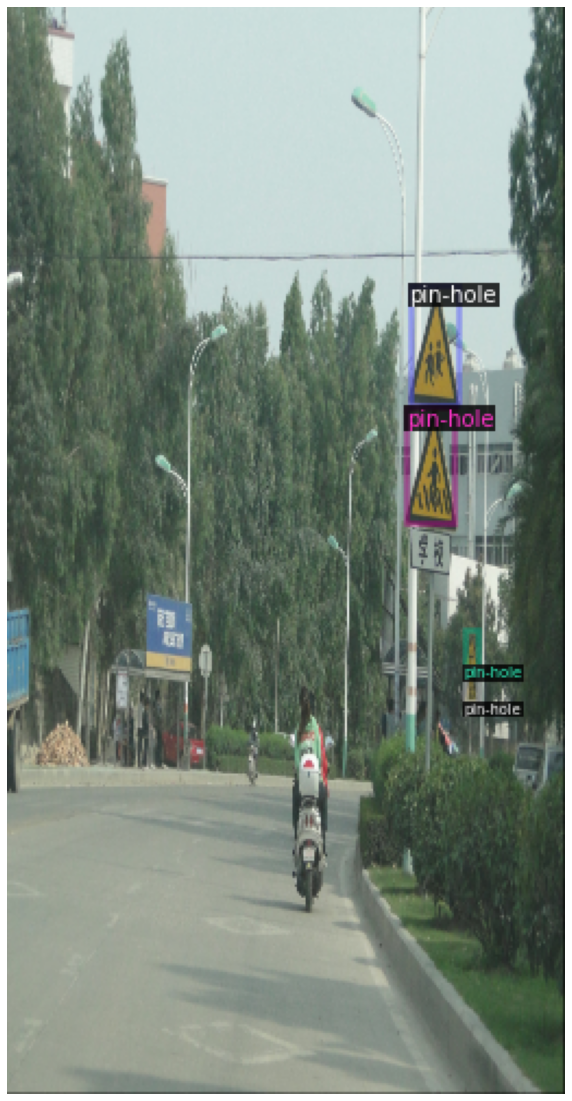

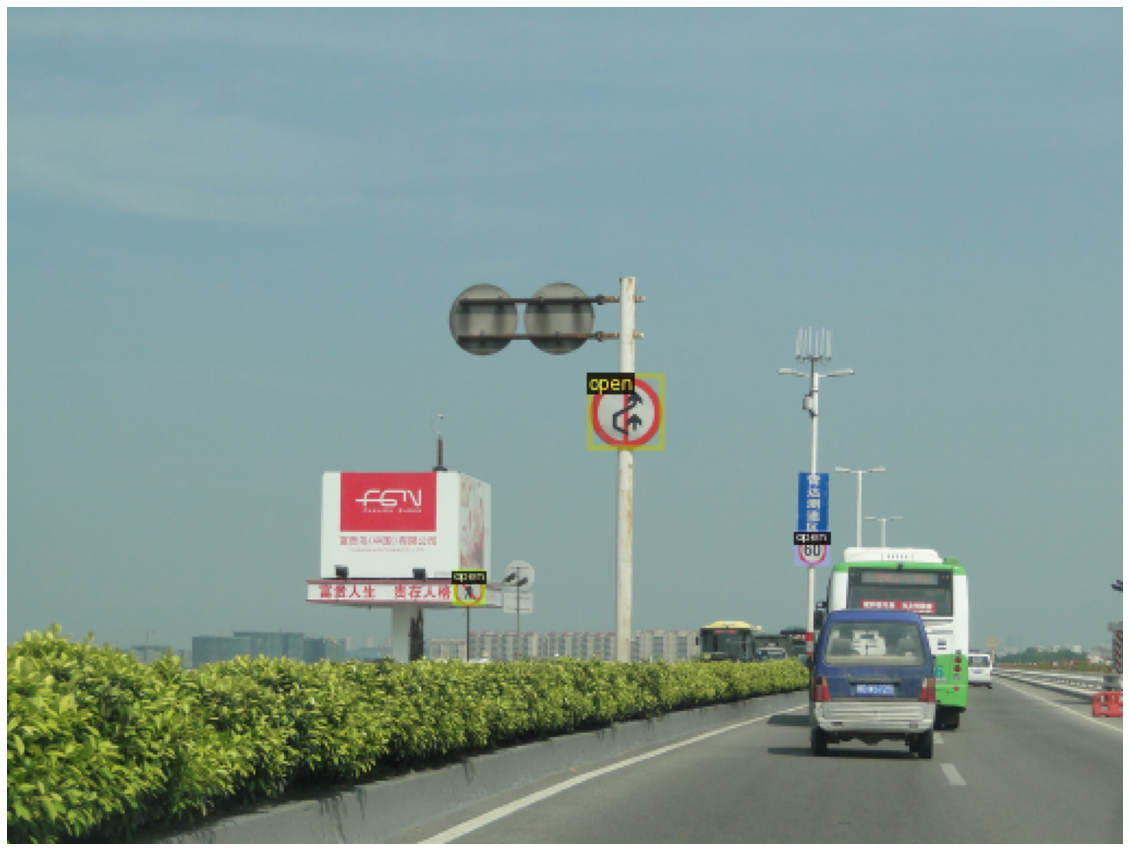

In [16]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PCB_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [22]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
trainer.train()
#It will train about 20 minutes in colab.

[05/22 21:30:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/22 21:30:22 d2.data.build]: Removed 0 images with no usable annotations. 57 images left.
[05/22 21:30:22 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[05/22 21:30:22 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/22 21:30:22 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/22 21:30:22 d2.data.build]: Using training sampler TrainingSampler
[05/22 21:30:22 d2.engine.train_loop]: Starting training from iteration 0
[05/22 21:30:32 d2.utils.events]:  eta: 0:02:35  iter: 19  total_loss: 16.209  loss_cls: 6.851  loss_box_reg: 1.839  loss_rpn_cls: 2.542  loss_rpn_loc: 3.778  time: 0.5473  data_time: 0.0925  lr: 0.000005  max_mem: 2836M
[05/22 21:30:44 d2.utils.events]:  eta: 0:02:31  iter: 39  total_loss: 7.053  loss_cls: 3.677  loss_box_reg: 1.132  loss_rpn_cls: 1.100  loss_rpn_loc: 0.991  time: 0.5710  d

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PCB_test", )
predictor = DefaultPredictor(cfg)

In [24]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_PCB_dict(test)

tensor([0], device='cuda:0')
Boxes(tensor([[464.3473, 427.3874, 501.6508, 639.5402]], device='cuda:0'))


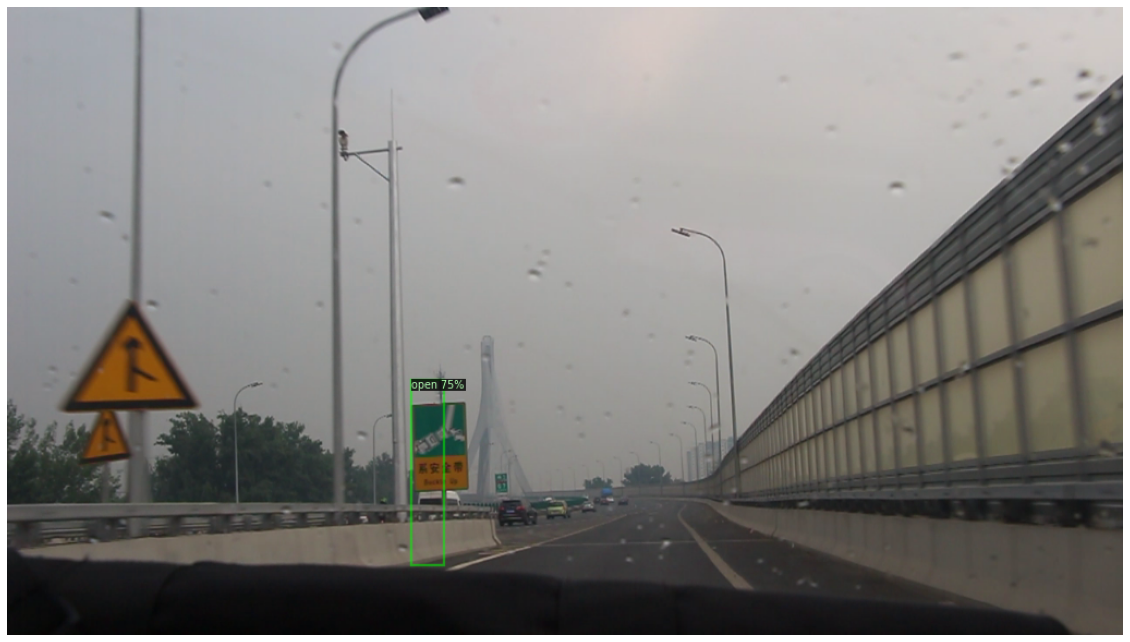

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


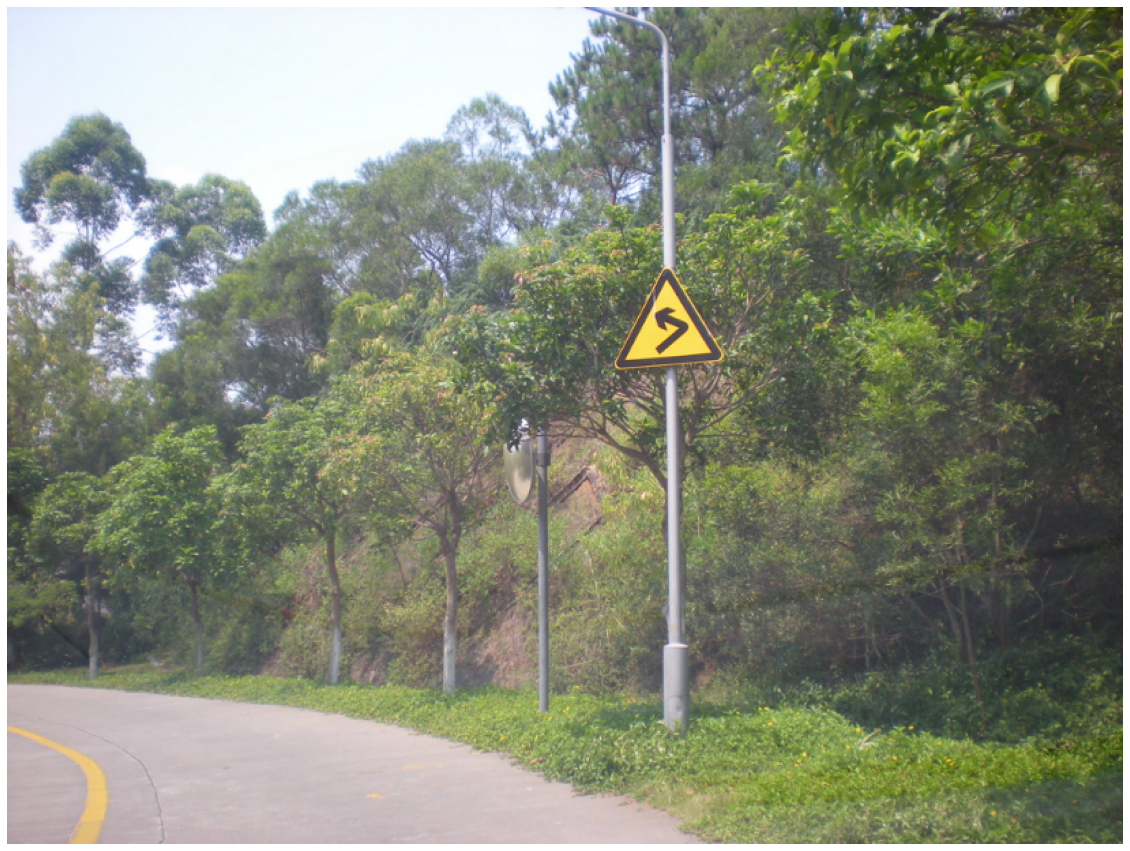

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


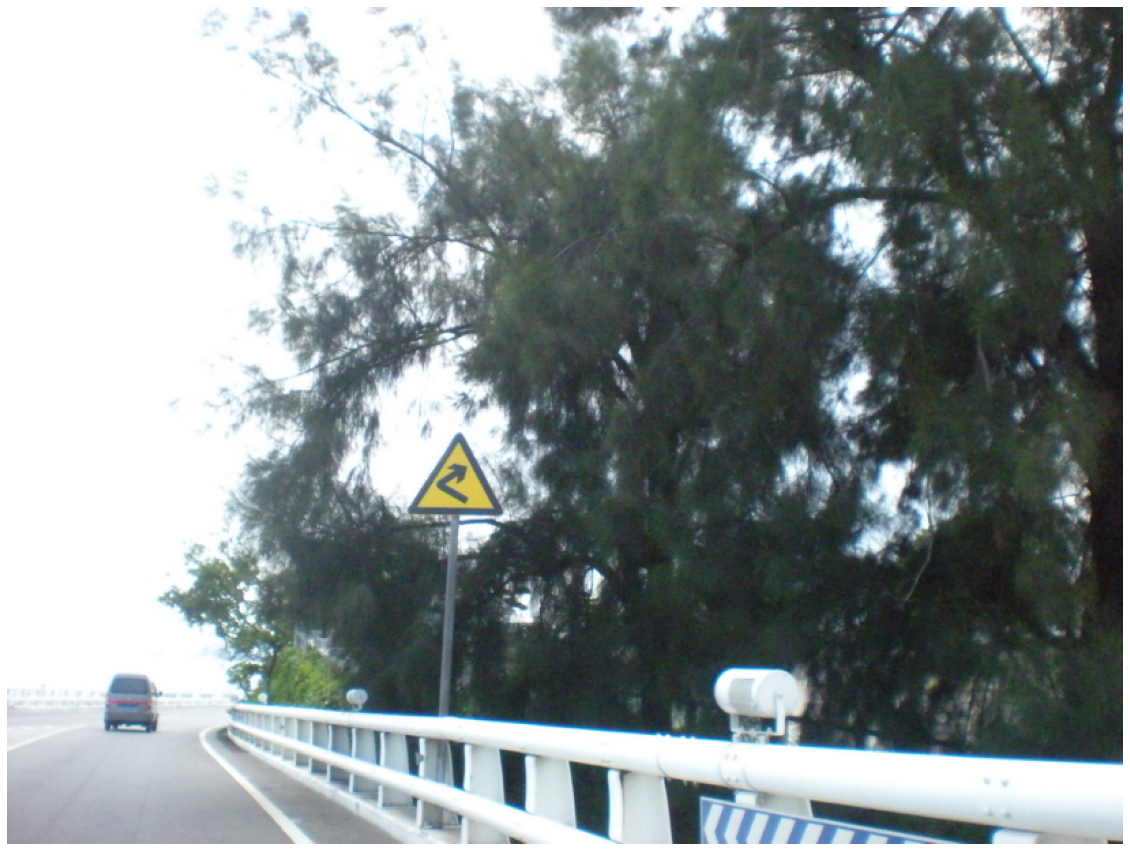

In [25]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im,
                   metadata=PCB_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    print(outputs['instances'].pred_classes)
    print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())

In [26]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("PCB_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "PCB_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[05/22 21:33:55 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[05/22 21:33:55 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/22 21:33:55 d2.evaluation.evaluator]: Start inference on 57 images
[05/22 21:33:57 d2.evaluation.evaluator]: Inference done 11/57. 0.1024 s / img. ETA=0:00:06
[05/22 21:34:02 d2.evaluation.evaluator]: Inference done 44/57. 0.1069 s / img. ETA=0:00:01
[05/22 21:34:04 d2.evaluation.evaluator]: Total inference time: 0:00:07.888506 (0.151702 s / img per device, on 1 devices)
[05/22 21:34:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.106865 s / img per device, on 1 devices)
[05/22 21:34:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/22 21:34:04 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[05/22 21:34:04 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating i

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 0.0,
               'AP-open': 0.0,
               'AP-short': 0.0,
               'AP-mousebite': 0.0,
               'AP-spur': 0.0,
               'AP-copper': 0.0,
               'AP-pin-hole': 0.0})])